<a href="https://colab.research.google.com/github/Amal-Alalami/FinalProject/blob/main/CNN_CLAHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# to generate data
from keras.preprocessing.image import ImageDataGenerator

# to build model
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
%matplotlib inline

# Upload Dataset

In [83]:
!7z x archive.zip



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 35779075 bytes (35 MiB)

Extracting archive: archive.zip
 64% 4096 Open              --
Path = archive.zip
Type = zip
Physical Size = 35779075

  0%     11% 771 - Alzheimer_s Dataset/test/NonDemented/32 (46).jpg                                                            22% 1522 - Alzheimer_s Dataset/train/MildDemented/mildDem317.jpg                                                                  33% 2197 - Alzheimer_s Dataset/train/Non

# **Pre-processed data and Visualize Sample Images**

In [40]:
# Method to print sample images from each class

def print_sample_images(train_path, class_labels):

  plt.figure(figsize=(10, 10))
  for i, class_name in enumerate(class_labels):

    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_path, class_name)))
    img_path = os.path.join(train_path, class_name, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

  plt.show()

**Sample of train images before pre-processing data from each class**

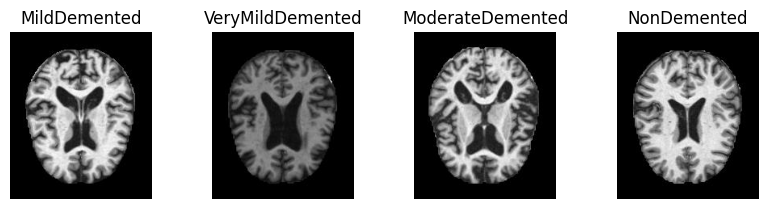

In [84]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

**Pre-processing data**

In [85]:
def process_images_in_folder(folder_path):
  width, height = 128, 128

  for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path)

    #pre-processing data using Contrast Limited Adaptive Histogram Equalization (CLAHE)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1)
    preprocessed_image = clahe.apply(gray_image)

    # Save the pre-processed image with the same filename
    cv2.imwrite(image_path, preprocessed_image)

In [86]:
train_data_path = '/content/Alzheimer_s Dataset/train'
test_data_path = '/content/Alzheimer_s Dataset/test'
class_labels = os.listdir('/content/Alzheimer_s Dataset/train')


def data_to_be_processed(class_path ,class_labels):
  for class_label in class_labels:
    class_folder_path = os.path.join(class_path, class_label)
    process_images_in_folder(class_folder_path)



# train data
data_to_be_processed(train_data_path, class_labels)

# test data
data_to_be_processed(test_data_path, class_labels)

**Sample of train images after pre-processing data from each class**

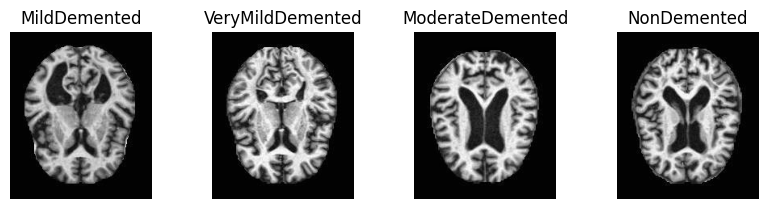

In [87]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

# Images in train data

In [88]:
train_folder = '/content/Alzheimer_s Dataset/train'
class_names_train_folder = os.listdir(train_folder)
class_count = []

for class_name in class_names_train_folder:
  num_images = len(os.listdir(os.path.join(train_folder, class_name)))
  class_count.append(num_images)
  print(f"Class {class_name}: {num_images} images")


Class MildDemented: 717 images
Class VeryMildDemented: 1792 images
Class ModerateDemented: 52 images
Class NonDemented: 2560 images


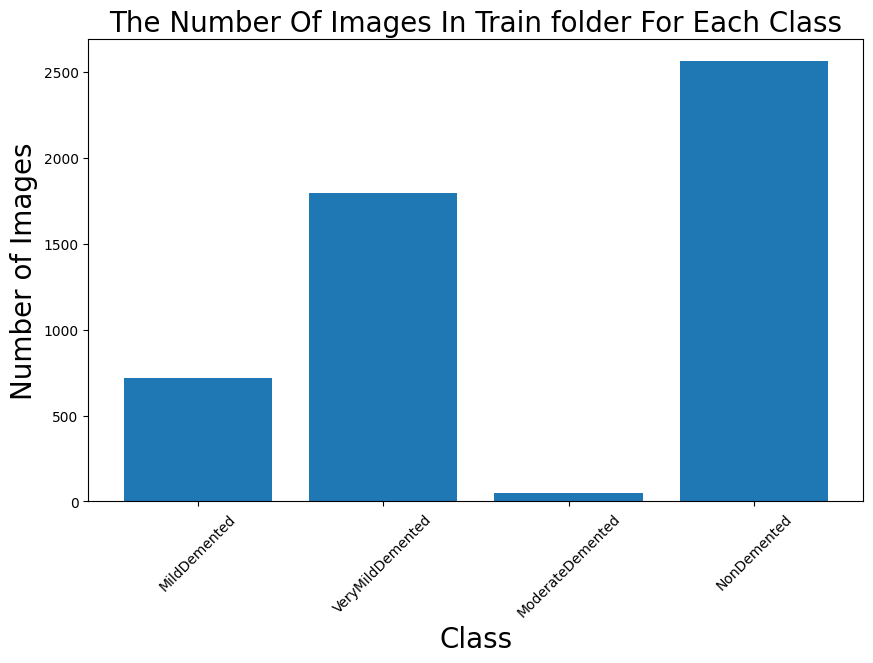

In [89]:

plt.figure(figsize=(10, 6))
plt.bar(class_names_train_folder, class_count)

plt.title('The Number Of Images In Train folder For Each Class', fontsize=20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Images", fontsize=20)
plt.xticks(rotation=45)

plt.show()


# **Train Test split and Build Model**

In [90]:
#  Loads all images and labels from a directory and converts them to a NumPy array.

def load_train_data(data_dir):

  image_width, image_height = 128, 128
  class_names = os.listdir(data_dir)
  class_name_to_label = {class_name: i for i, class_name in enumerate(class_names)}
  images = []
  labels = []

  for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):

      image_path = os.path.join(class_path, filename)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      image = cv2.resize(image, (image_width, image_height))
      image = image / 255.0 #normalize

      label = class_name_to_label[class_name]
      images.append(image)
      labels.append(label)

  # Convert the list of images to a NumPy array
  X_train = np.asarray(images)
  Y_train = np.asarray(labels)

  return X_train, Y_train

In [91]:
X_train , Y_train = load_train_data('/content/Alzheimer_s Dataset/train')

In [92]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: (5121, 128, 128)
Y_train shape: (5121,)


In [93]:
Y_train

array([0, 0, 0, ..., 3, 3, 3])

In [94]:
Y_train = tf.keras.utils.to_categorical(Y_train)

In [95]:
Y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [96]:
print(Y_train.shape)

(5121, 4)


In [97]:
X_test , Y_test = load_train_data('/content/Alzheimer_s Dataset/test')

In [98]:
print(f"X_test original shape: {X_test.shape}")
print(f"Y_test original shape: {Y_test.shape}")

X_test original shape: (1279, 128, 128)
Y_test original shape: (1279,)


In [99]:
X_val, X_test, Y_val , Y_test = train_test_split(X_test, Y_test, test_size=0.7, random_state=42)

In [100]:
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_test shape: (896, 128, 128)
Y_test shape: (896,)


In [101]:
print(f"X_validation shape: {X_val.shape}")
print(f"Y_validation shape: {Y_val.shape}")

X_validation shape: (383, 128, 128)
Y_validation shape: (383,)


In [102]:
Y_val

array([1, 3, 3, 0, 3, 3, 3, 0, 2, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 0,
       0, 1, 1, 0, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 0, 0, 3, 1, 3, 3,
       0, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 1, 1, 3, 1, 0, 3, 0, 3, 3, 1, 3,
       3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 3, 3, 3, 3, 1, 0, 2, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 0, 1, 1, 3, 3, 3, 3, 3,
       1, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 0, 1, 0, 0, 1,
       3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 3, 0, 1, 3, 0, 0, 1, 1, 3, 0, 3,
       3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 0, 1, 3, 3, 3, 1, 3, 1, 3, 0, 1,
       3, 3, 3, 1, 1, 1, 0, 3, 3, 1, 3, 1, 1, 3, 1, 0, 1, 3, 1, 3, 3, 1,
       3, 1, 3, 0, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3,
       1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 1, 0, 3, 0, 3,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 0, 0, 3, 3,

In [103]:
Y_val_cat = tf.keras.utils.to_categorical(Y_val)

In [104]:
Y_val_cat

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [105]:
print(Y_val_cat.shape)

(383, 4)


In [106]:
Y_test

array([3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 3, 1, 1, 3, 3,
       1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 0, 1, 3, 3, 1, 1, 3, 0,
       1, 3, 1, 0, 3, 3, 3, 3, 0, 0, 0, 1, 0, 3, 3, 3, 1, 1, 3, 3, 1, 3,
       3, 1, 3, 3, 3, 1, 3, 0, 0, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1,
       3, 1, 0, 1, 3, 3, 3, 0, 1, 0, 1, 3, 1, 1, 2, 3, 0, 3, 1, 1, 0, 3,
       1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 1,
       3, 3, 0, 3, 3, 0, 3, 3, 3, 0, 1, 1, 1, 1, 1, 3, 3, 1, 0, 0, 3, 1,
       3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 1, 3, 3, 3,
       2, 0, 1, 1, 1, 1, 0, 3, 3, 1, 0, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 1,
       3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 0, 1, 1, 1, 1, 1,
       3, 1, 0, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 0, 3, 3, 3, 1, 1,
       0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 0, 3, 3, 3,
       1, 1, 3, 3, 0, 1, 3, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3,
       3, 1, 1, 3, 0, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3,

In [107]:
Y_test_cat = tf.keras.utils.to_categorical(Y_test)

In [108]:
print(Y_test_cat.shape)

(896, 4)


In [109]:
Y_test_cat

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [110]:
# CNN model
model1 = Sequential()
inputSize = (128,128,1)

#ilters=32, kernel_size=(4,4), input_shape=(28,28,1), activation='relu')
model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Flatten())

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(4, activation = 'softmax'))
model1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [111]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)       

In [112]:
results = model1.fit(X_train, Y_train, epochs=35, validation_data=(X_val, Y_val_cat))

Epoch 1/35
161/161 [==============================] - 104s 638ms/step - loss: 1.0074 - accuracy: 0.5108 - val_loss: 0.9396 - val_accuracy: 0.5692
Epoch 2/35
161/161 [==============================] - 94s 585ms/step - loss: 0.8507 - accuracy: 0.6055 - val_loss: 0.8578 - val_accuracy: 0.6136
Epoch 3/35
161/161 [==============================] - 95s 592ms/step - loss: 0.6122 - accuracy: 0.7336 - val_loss: 0.8686 - val_accuracy: 0.6449
Epoch 4/35
161/161 [==============================] - 96s 600ms/step - loss: 0.3872 - accuracy: 0.8414 - val_loss: 1.4387 - val_accuracy: 0.5718
Epoch 5/35
161/161 [==============================] - 95s 592ms/step - loss: 0.1956 - accuracy: 0.9276 - val_loss: 1.2000 - val_accuracy: 0.6815
Epoch 6/35
161/161 [==============================] - 96s 595ms/step - loss: 0.0871 - accuracy: 0.9709 - val_loss: 1.7514 - val_accuracy: 0.6345
Epoch 7/35
161/161 [==============================] - 95s 588ms/step - loss: 0.0336 - accuracy: 0.9906 - val_loss: 1.4926 - val_a

In [113]:
print(model1.output_shape)

(None, 4)


In [114]:
hist_=pd.DataFrame(results.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,1.007392,0.510838,0.939565,0.569191
1,0.850662,0.605546,0.857806,0.613577
2,0.612190,0.733646,0.868572,0.644909
3,0.387193,0.841437,1.438732,0.571802
4,0.195641,0.927553,1.200049,0.681462
5,0.087057,0.970904,1.751363,0.634465
6,0.033585,0.990627,1.492633,0.686684
7,0.022540,0.993946,1.578499,0.652741
8,0.022480,0.994532,2.091886,0.673629
9,0.027253,0.991994,1.580583,0.665796


# **Model Evaluation**

In [115]:
loss, acc = model1.evaluate(X_test, Y_test_cat)
print('loss: ', loss)
print('accuracy ', acc)

28/28 [==============================] - 5s 188ms/step - loss: 2.7060 - accuracy: 0.6953
loss:  2.7059779167175293
accuracy  0.6953125


In [116]:
# Reshape Y_test to a 1-dimensional array
Y_test = Y_test.reshape(-1,)

predictions = model1.predict(X_test)
Y_predected = np.argmax(predictions, axis=1)
#Y_test_ = np.argmax(Y_test,axis=0)

df = pd.DataFrame({'Actual': Y_test, 'Prediction': Y_predected})
df

28/28 [==============================] - 4s 147ms/step


,Actual,Prediction
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3
...,...,...
891,0,0
892,1,1
893,3,3
894,3,1


array([[ 50,  45,   0,  32],
       [ 15, 278,   1,  36],
       [  3,   1,   4,   0],
       [ 12, 128,   0, 291]])

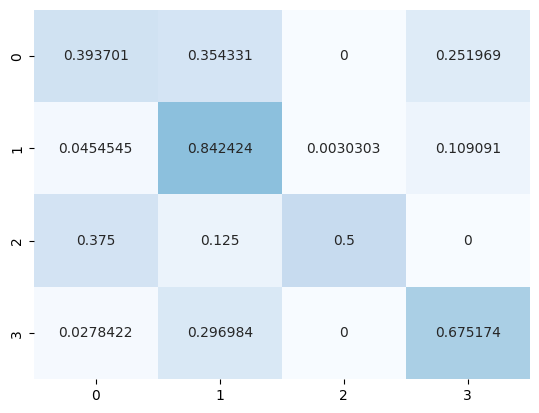

In [117]:
CM = confusion_matrix(Y_test,Y_predected)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [118]:
print(classification_report(Y_test, Y_predected))

              precision    recall  f1-score   support

           0       0.62      0.39      0.48       127
           1       0.62      0.84      0.71       330
           2       0.80      0.50      0.62         8
           3       0.81      0.68      0.74       431

    accuracy                           0.70       896
   macro avg       0.71      0.60      0.64       896
weighted avg       0.71      0.70      0.69       896

